In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [145]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [146]:
df = pd.read_excel('testing dataset.xlsx')

In [147]:
df.head()

,year,month,day,CO2 molfrac (PPM)
0,1974,5,19,333.46
1,1974,5,20,333.64
2,1974,5,21,333.50
3,1974,5,22,333.21
4,1974,5,23,333.05


In [148]:
df.tail()

,year,month,day,CO2 molfrac (PPM)
15829,2026,1,31,428.04
15830,2026,2,1,427.76
15831,2026,2,2,428.24
15832,2026,2,3,427.98
15833,2026,2,4,428.87


In [149]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.drop(columns=['year', 'month', 'day'])

In [150]:
df.head()

,CO2 molfrac (PPM),date
0,333.46,1974-05-19
1,333.64,1974-05-20
2,333.50,1974-05-21
3,333.21,1974-05-22
4,333.05,1974-05-23


In [151]:
df = df.set_index('date')

In [152]:
df.index.min(), df.index.max()

(Timestamp('1974-05-19 00:00:00'), Timestamp('2026-02-04 00:00:00'))

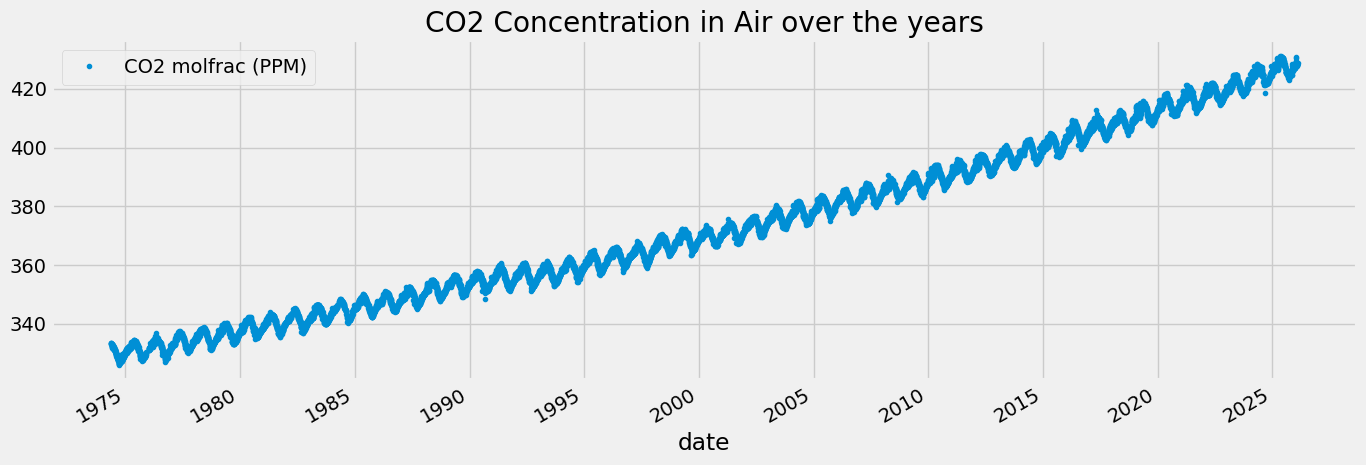

In [153]:
ax = df.plot(
    style='.',
    figsize=(15, 5),
    color = color_pal[0],
    title = 'CO2 Concentration in Air over the years'
);

ax.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# Train/Test Split

In [154]:
train = df.iloc[df.index<'01-01-2015']
test = df.iloc[df.index>='01-01-2015']

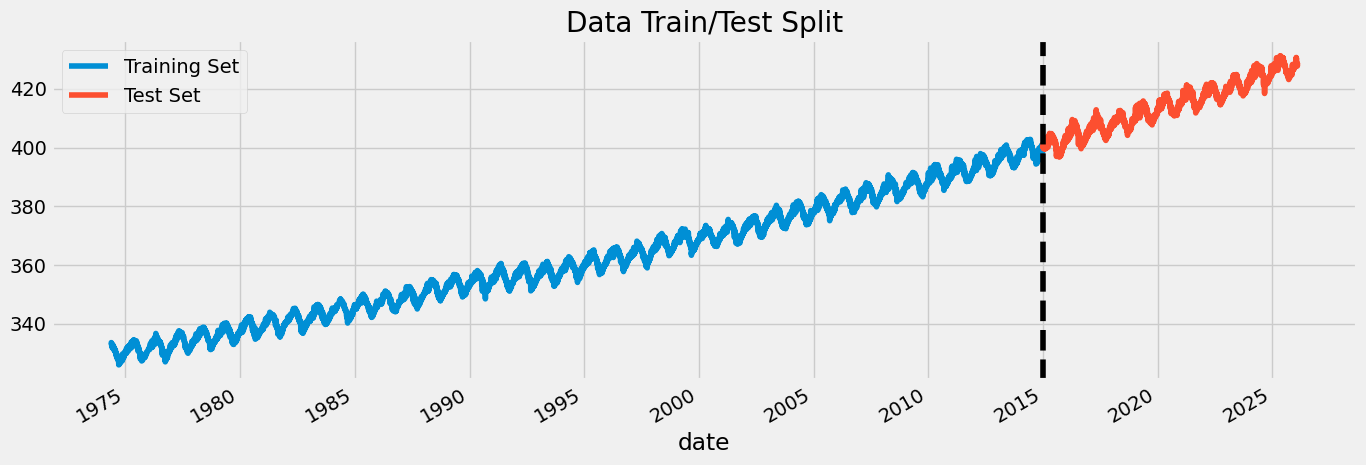

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])

ax.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

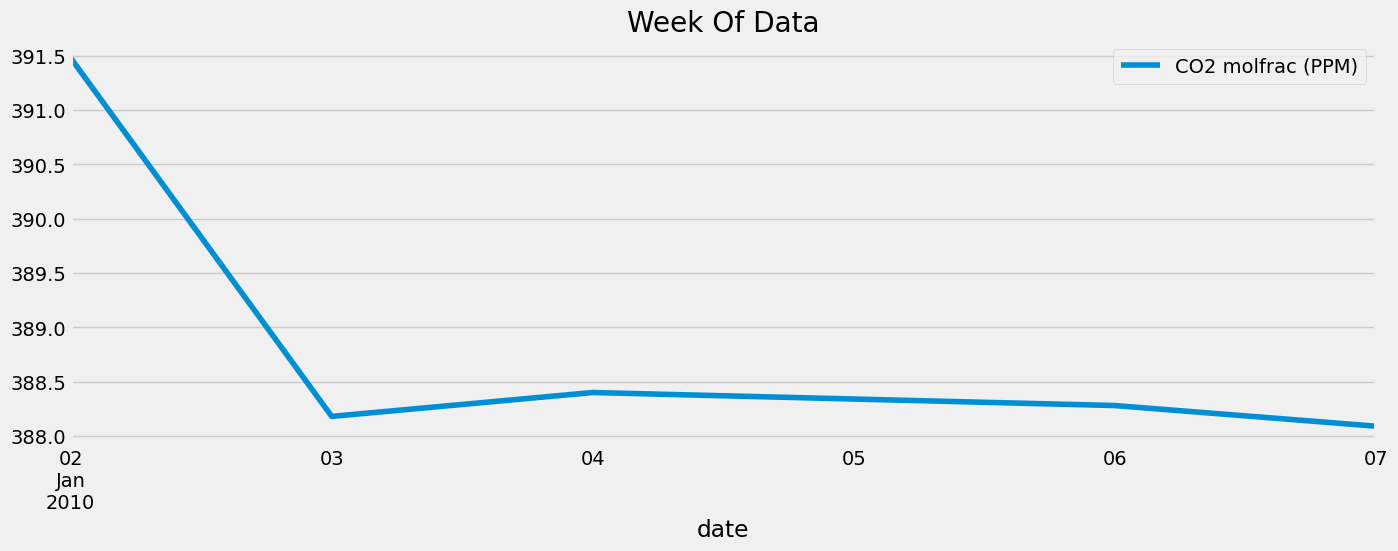

In [156]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [157]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

C:\Users\singh\AppData\Local\Temp\ipykernel_11396\2766211311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='CO2 molfrac (PPM)', palette='Blues')


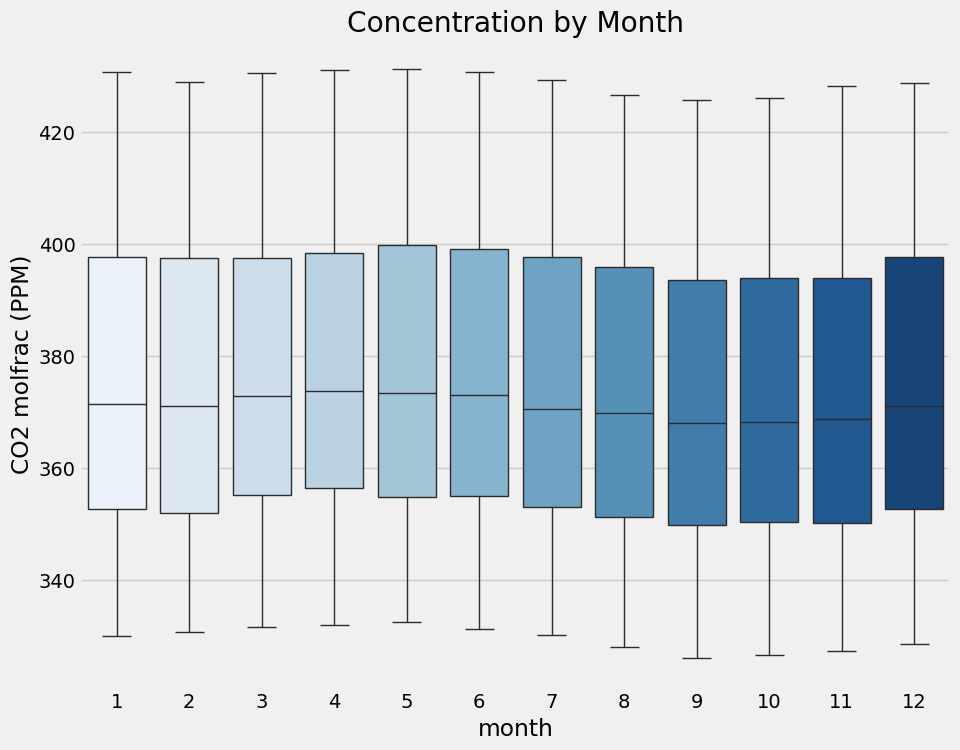

In [158]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='CO2 molfrac (PPM)', palette='Blues')
ax.set_title('Concentration by Month')
plt.show()

# Create our Model

In [159]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'CO2 molfrac (PPM)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [160]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:359.62317	validation_1-rmse:409.56271
[100]	validation_0-rmse:131.72405	validation_1-rmse:163.05303
[200]	validation_0-rmse:48.27651	validation_1-rmse:71.06801


C:\Users\singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:01:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:17.73460	validation_1-rmse:37.06365
[400]	validation_0-rmse:6.57464	validation_1-rmse:24.73872
[500]	validation_0-rmse:2.53200	validation_1-rmse:20.21670
[600]	validation_0-rmse:1.14265	validation_1-rmse:18.50933
[700]	validation_0-rmse:0.72923	validation_1-rmse:17.79442
[800]	validation_0-rmse:0.62318	validation_1-rmse:17.46610
[900]	validation_0-rmse:0.59160	validation_1-rmse:17.29350
[999]	validation_0-rmse:0.57850	validation_1-rmse:17.19965


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

In [161]:
reg.feature_importances_

array([4.3979697e-03, 5.5681403e-06, 8.6626755e-03, 5.4579894e-03,
       9.8147583e-01], dtype=float32)

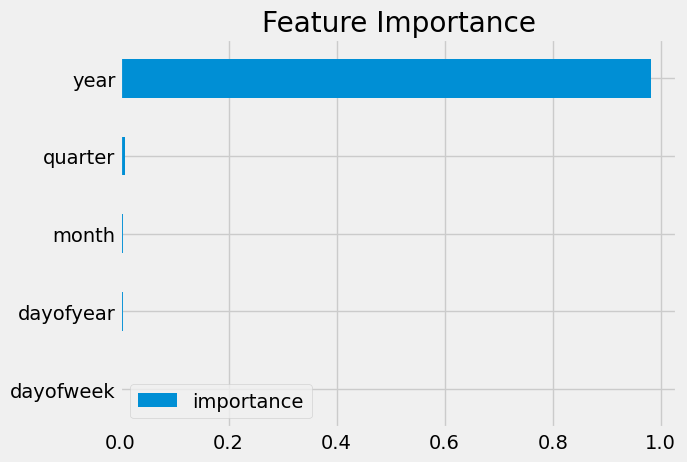

In [162]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forcast on Test

In [163]:
reg.predict(X_test)

array([397.71655, 397.71655, 397.71655, ..., 398.20218, 398.20218,
       398.20218], shape=(3534,), dtype=float32)

In [164]:
test['prediction'] = reg.predict(X_test)

In [165]:
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

,CO2 molfrac (PPM),dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
date,,,,,,,,,
1974-05-19,333.46,6,2,5,1974,139,19,20,NaN
1974-05-20,333.64,0,2,5,1974,140,20,21,NaN
1974-05-21,333.50,1,2,5,1974,141,21,21,NaN
1974-05-22,333.21,2,2,5,1974,142,22,21,NaN
1974-05-23,333.05,3,2,5,1974,143,23,21,NaN
...,...,...,...,...,...,...,...,...,...
2026-01-31,428.04,5,1,1,2026,31,31,5,398.183624
2026-02-01,427.76,6,1,2,2026,32,1,5,398.191864
2026-02-02,428.24,0,1,2,2026,33,2,6,398.202179


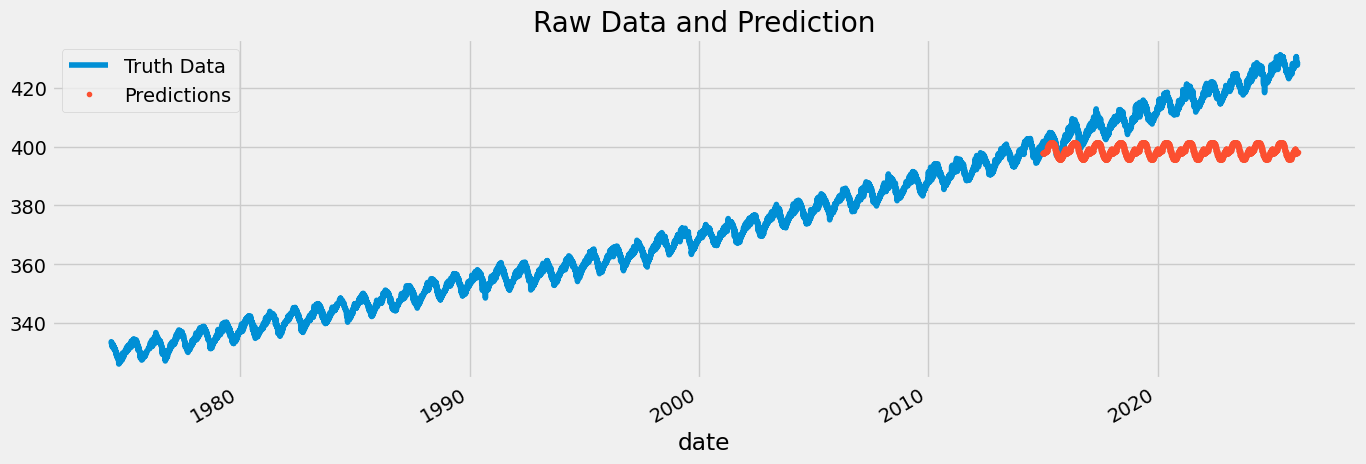

In [166]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['CO2 molfrac (PPM)']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

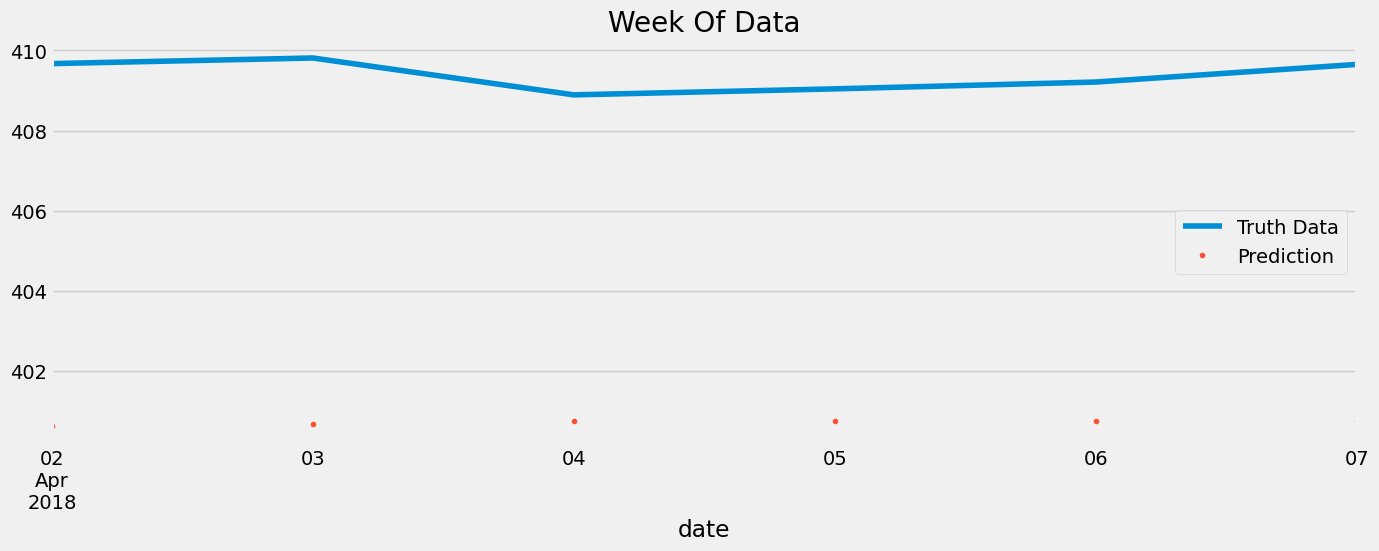

In [167]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['CO2 molfrac (PPM)'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [168]:
score = np.sqrt(mean_squared_error(test['CO2 molfrac (PPM)'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 17.20


# Calculate Error
- Look at the worst and best predicted days

In [169]:
np.abs(test[TARGET] - test['prediction'])

date
2015-01-01     4.063447
2015-01-02     2.303447
2015-01-03     2.633447
2015-01-04     2.419604
2015-01-05     1.967642
                ...    
2026-01-31    29.856376
2026-02-01    29.568136
2026-02-02    30.037821
2026-02-03    29.777821
2026-02-04    30.667821
Length: 3534, dtype: float64

In [170]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [171]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

test.groupby(test.index)['error'] \
    .mean() \
    .sort_values(ascending=False) \
    .head(10)

date
2026-01-14    32.746447
2026-01-17    32.510671
2025-03-07    31.848169
2026-01-06    31.402211
2026-01-16    31.390671
2025-03-10    31.068235
2026-01-24    30.885902
2025-11-15    30.836448
2026-01-22    30.834121
2026-01-02    30.823447
Name: error, dtype: float64

In [172]:
test.groupby(test.index)['error'] \
    .mean() \
    .sort_values(ascending=True) \
    .head(10)

date
2015-08-04    0.172810
2015-03-20    0.274827
2015-03-19    0.414827
2015-04-04    0.450112
2015-04-02    0.495793
2015-03-25    0.571096
2015-03-18    0.704827
2015-04-01    0.728467
2015-07-28    0.776758
2015-03-17    0.778518
Name: error, dtype: float64

In [174]:
reg.save_model("co2_xgb.json")